# Proyek Klasifikasi Gambar: Face Mask Dataset Classification
- **Nama:** Michelle Angelina
- **Email:** zmichelleangelina@gmail.com
- **ID Dicoding:** mchelle_angelina

## Import Semua Packages/Library yang Digunakan

In [20]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import gc

!pip install split-folders > /dev/null 2>&1
!pip install tensorflowjs --upgrade > /dev/null 2>&1
!pip install tensorflow > /dev/null 2>&1

import shutil
import cv2
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import zipfile
from google.colab import files
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

import tensorflowjs as tfjs

## Data Preparation

### Data Loading

In [2]:
# Import Kaggle menggunakan file JSON untuk men-download dataset dari: https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset
files.upload()

!pip install kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shiekhburhan/face-mask-dataset > /dev/null 2>&1

with zipfile.ZipFile("face-mask-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("FMD_DATASET")

dataset_dir = 'FMD_DATASET/FMD_DATASET'
image_count = sum([len(files) for r, d, files in os.walk(dataset_dir)])

# Berhasil download
print(f"Dataset berhasil di-download sebanyak {image_count} gambar dalam data. Dataset yang digunakan minimal 10000 gambar untuk meningkatkan akurasi.")

Saving kaggle.json to kaggle.json
Dataset berhasil di-download sebanyak 14536 gambar dalam data. Dataset yang digunakan minimal 10000 gambar untuk meningkatkan akurasi.


In [3]:
## Membuat resolusi dataset dijamin tidak seragam
def make_random_resolution(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        output_class_path = os.path.join(output_dir, class_folder)

        if not os.path.isdir(class_path):
            continue

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Ada subfolder di setiap kelas
        for sub_folder in os.listdir(class_path):
            sub_folder_path = os.path.join(class_path, sub_folder)
            output_sub_folder_path = os.path.join(output_class_path, sub_folder)

            if not os.path.isdir(sub_folder_path):
                continue

            if not os.path.exists(output_sub_folder_path):
                os.makedirs(output_sub_folder_path)

            for img_name in os.listdir(sub_folder_path):
                img_path = os.path.join(sub_folder_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None: # Resolusi dibuat tidak seragam secara acak
                        new_width = np.random.randint(50, 150)
                        new_height = np.random.randint(50, 150)
                        resized_img = cv2.resize(img, (new_width, new_height))
                        # Simpan di folder direktori baru
                        output_img_path = os.path.join(output_sub_folder_path, img_name)
                        cv2.imwrite(output_img_path, resized_img)
                    else:
                        print(f"Gambar tidak valid: {img_path}")
                except Exception as e:
                    # Error log
                    print(f"Kesalahan saat memproses {img_path}: {e}")

input_dir = "FMD_DATASET/FMD_DATASET"
random_output_dir = "FMD_DATASET/Random_Resolution"
make_random_resolution(input_dir, random_output_dir)

print("Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.")

for root, dirs, files in os.walk(random_output_dir):
    print(f"Path: {root}, Jumlah Gambar: {len(files)}")

Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.
Path: FMD_DATASET/Random_Resolution, Jumlah Gambar: 0
Path: FMD_DATASET/Random_Resolution/with_mask, Jumlah Gambar: 0
Path: FMD_DATASET/Random_Resolution/with_mask/complex, Jumlah Gambar: 789
Path: FMD_DATASET/Random_Resolution/with_mask/simple, Jumlah Gambar: 4000
Path: FMD_DATASET/Random_Resolution/incorrect_mask, Jumlah Gambar: 0
Path: FMD_DATASET/Random_Resolution/incorrect_mask/mmc, Jumlah Gambar: 2500
Path: FMD_DATASET/Random_Resolution/incorrect_mask/mc, Jumlah Gambar: 2500
Path: FMD_DATASET/Random_Resolution/without_mask, Jumlah Gambar: 0
Path: FMD_DATASET/Random_Resolution/without_mask/complex, Jumlah Gambar: 747
Path: FMD_DATASET/Random_Resolution/without_mask/simple, Jumlah Gambar: 4000


### Data Preprocessing

In [4]:
try:
    shutil.rmtree('FMD_DATASET/Random_Resolution_Rerouted')
    print("Folder 'Random_Resolution_Rerouted' and its contents removed successfully.")
except FileNotFoundError:
    print("Folder 'Random_Resolution_Rerouted' not found.")
except OSError as e:
    print(f"Error removing folder: {e}")

Folder 'Random_Resolution_Rerouted' not found.


In [5]:
# Membuat direktori untuk 3 kelas utama tanpa subdirektori: 'with_mask', 'without_mask', 'incorrect_mask' untuk mempermudah model
destination_dir = 'FMD_DATASET/Random_Resolution_Rerouted'
os.makedirs(os.path.join(destination_dir, 'with_mask'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'without_mask'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'incorrect_mask'), exist_ok=True)

def move_images(src_folder, dest_folder):
    for category in ['with_mask', 'without_mask', 'incorrect_mask']:
        category_path = os.path.join(src_folder, category)

        if os.path.isdir(category_path):
            for root, _, files in os.walk(category_path):
                for file in files:
                    subfolder_name = os.path.basename(root)
                    file_path = os.path.join(root, file)

                    unique_name = f"{subfolder_name}_{file}"
                    dest_path = os.path.join(dest_folder, category, unique_name)
                    shutil.move(file_path, dest_path)

move_images(random_output_dir, destination_dir)

print("Dataset berhasil direstrukturisasi menjadi 3 kelas utama: 'with_mask', 'without_mask', dan 'incorrect_mask'. Dataset memiliki 3 buah kelas.")

for category in ['with_mask', 'without_mask', 'incorrect_mask']:
    category_path = os.path.join(destination_dir, category)
    num_files = len(os.listdir(category_path))
    print(f"Jumlah data di kategori '{category}': {num_files}")

Dataset berhasil direstrukturisasi menjadi 3 kelas utama: 'with_mask', 'without_mask', dan 'incorrect_mask'. Dataset memiliki 3 buah kelas.
Jumlah data di kategori 'with_mask': 4789
Jumlah data di kategori 'without_mask': 4747
Jumlah data di kategori 'incorrect_mask': 5000


#### Split Dataset

In [6]:
# Dataset Dibagi Menjadi 80% Train Set dan 20% Test Set
input_dir = "FMD_DATASET/Random_Resolution_Rerouted"
output_dir = "FMD_DATASET/Split_Data"

# Split dataset (80/20 untuk pembagian training dan testing)
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=(0.8, 0.2))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # Augmentasi data
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Testing set tidak perlu augmentasi data, hanya training
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    "FMD_DATASET/Split_Data/train",
    target_size=(128, 128), # Menyamakan resolusi data
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    "FMD_DATASET/Split_Data/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

## Hasil Split Data
base_dir = "FMD_DATASET/Split_Data/train"
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        print(f"Training Set Category: {category}, Number of data: {len(os.listdir(category_path))}")

base_dir = "FMD_DATASET/Split_Data/val"
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        print(f"Testing Set Category: {category}, Number of data: {len(os.listdir(category_path))}")

Copying files: 14536 files [00:07, 2059.50 files/s]


Found 11628 images belonging to 3 classes.
Found 2908 images belonging to 3 classes.
Training Set Category: with_mask, Number of data: 3831
Training Set Category: incorrect_mask, Number of data: 4000
Training Set Category: without_mask, Number of data: 3797
Testing Set Category: with_mask, Number of data: 958
Testing Set Category: incorrect_mask, Number of data: 1000
Testing Set Category: without_mask, Number of data: 950


## Modelling

In [7]:
## Menghitung Class Weight
class_labels = list(train_generator.class_indices.keys())

class_counts = []
for label in class_labels:
    class_folder = os.path.join(train_generator.directory, label)
    num_images = sum([len(files) for _, _, files in os.walk(class_folder)])
    class_counts.append(num_images)
y = []

for label, count in zip(class_labels, class_counts):
    y.extend([label] * count)

class_weight_dict = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=np.array(y)
)


class_weight_dict = {label: weight for label, weight in zip(class_labels, class_weight_dict)}
print("Class Weights:", class_weight_dict)

Class Weights: {'incorrect_mask': 0.969, 'with_mask': 1.0117462803445576, 'without_mask': 1.0208058993942586}


In [8]:
IMG_SIZE = 128

# Building model CNN dengan Model Sequential, Conv2D, Pooling Layer
model = Sequential([
    # 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),

    # 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Mengimplementasikan Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    validation_steps=test_generator.samples,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.6784 - loss: 0.7222 - val_accuracy: 0.8999 - val_loss: 0.3046
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.8572 - loss: 0.3922 - val_accuracy: 0.9175 - val_loss: 0.2485
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.8843 - loss: 0.3213 - val_accuracy: 0.9213 - val_loss: 0.2189
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.8889 - loss: 0.2940 - val_accuracy: 0.9140 - val_loss: 0.2319
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.8987 - loss: 0.2800 - val_accuracy: 0.9464 - val_loss: 0.1567
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9142 - loss: 0.2535 - val_accuracy: 0.9402 - val_loss: 0.1728
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.9157 - loss: 0.2426 - val_accuracy: 0.9519 - val_loss: 0.1383
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9297 - loss: 0.2111 - val_accu

## Evaluasi dan Visualisasi

In [9]:
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Testing Accuracy: {test_acc * 100:.2f}%")
print(f"Testing Loss: {test_loss:.4f}")

364/364 ━━━━━━━━━━━━━━━━━━━━ 171s 469ms/step - accuracy: 0.9426 - loss: 0.1561
Training Accuracy: 94.50%
Training Loss: 0.1537
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.9595 - loss: 0.1121
Testing Accuracy: 95.56%
Testing Loss: 0.1279


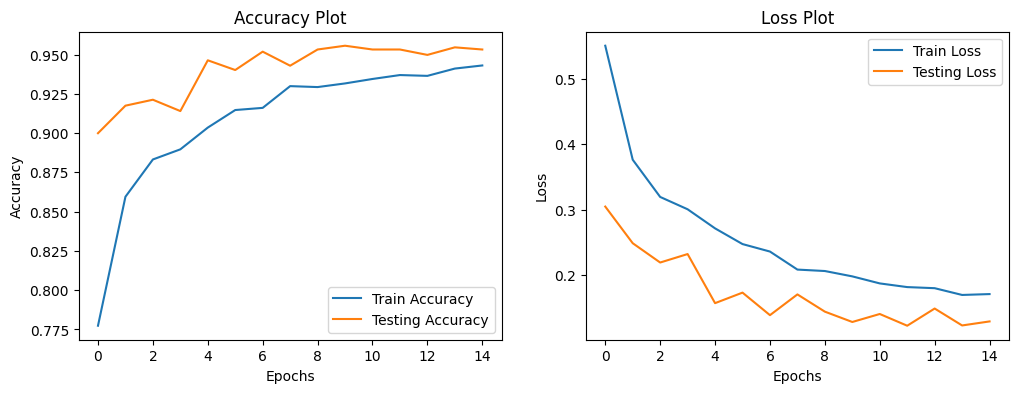

In [10]:
## Membuat Plot Terhadap Akurasi dan Loss Model
plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Plot')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Plot')

plt.show()

91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step
F1 Score (Macro): 0.9555189780677323


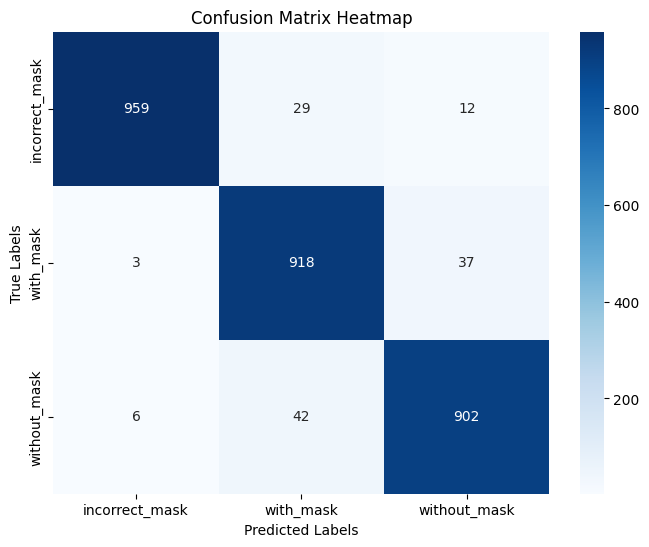

In [11]:
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = test_generator.classes

f1 = f1_score(Y_true, Y_pred_classes, average='macro')
print(f'F1 Score (Macro): {f1}')

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Konversi Model

In [12]:
# pip freeze untuk membuat requirements.txt untuk submission
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2025.1.20.0.32.27
astunparse==1.6.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.33.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.9.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.3.1
cryptography==4

In [14]:
## temporary save model jika crash
model.save("model_backup.h5")
model = tf.keras.models.load_model("model_backup.h5")

In [15]:
# SavedModel
saved_model_dir = "submission/saved_model"
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan dalam format SavedModel
tf.saved_model.save(model, saved_model_dir)

print(f"Model berhasil disimpan dalam format SavedModel di {saved_model_dir}")

Model berhasil disimpan dalam format SavedModel di submission/saved_model


In [16]:
# Simpan dengan format Keras Native
model.save("submission/my_model.keras")

# Simpan dengan format HDF5
model.save("submission/my_model.h5")

In [26]:
saved_model_dir = "saved_model_dir"
model.export(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

tflite_model_path = "submission/tflite/model.tflite"
os.makedirs(os.path.dirname(tflite_model_path), exist_ok=True)

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TFLite dan disimpan di {tflite_model_path}")

Saved artifact at 'saved_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135292084753936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084750096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084752592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084751056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084752400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084748944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084749136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084749520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292084749328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135292094182992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil dik

In [21]:
tfjs_output_dir = "submission/tfjs_model"
os.makedirs(tfjs_output_dir, exist_ok=True)

# Konversi model ke TFJS
tfjs.converters.convert_tf_saved_model("submission/saved_model", tfjs_output_dir)
print(f"Model berhasil dikonversi ke format TFJS di {tfjs_output_dir}")

Model berhasil dikonversi ke format TFJS di submission/tfjs_model


In [30]:
source_dir = "submission"

# Define the destination directory (where you want to zip the files)
destination_dir = "."  # Current directory

# Create a zip archive of the 'submission' directory
shutil.make_archive(f"{destination_dir}/submission", 'zip', source_dir)

print(f"Successfully created submission.zip")

Successfully created submission.zip


## Inference (Optional)

In [29]:
uploaded = files.upload()

# model TFLite
tflite_model_path = '/content/submission/tflite/model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

img_path = next(iter(uploaded))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=0).astype(np.float32)

input_index = input_details[0]['index']
interpreter.set_tensor(input_index, img)

interpreter.invoke()
output_index = output_details[0]['index']
output_data = interpreter.get_tensor(output_index)

class_labels = ['with_mask', 'without_mask', 'incorrect_mask']
predicted_class = class_labels[np.argmax(output_data)]
confidence = np.max(output_data)

# Hasil
print(f'Predicted Class dari Gambar: {predicted_class}')
if predicted_class == "with_mask":
    print("Penggunaan Masker yang Benar")
elif predicted_class == "without_mask":
    print("Tidak Menggunakan Masker")
elif predicted_class == "incorrect_mask":
    print("Penggunaan Masker yang Salah")
print(f'Confidence: {confidence}')

Saving tes_bad_mask.jpg to tes_bad_mask.jpg
Predicted Class dari Gambar: incorrect_mask
Penggunaan Masker yang Salah
Confidence: 0.7301456332206726
